# CA2 Face Recognition                                                                        
# Name：Dong Xinyue ID：E1124282
# Question4: SVM

In [2]:
import os
import matplotlib.pyplot as plt
from PIL import Image

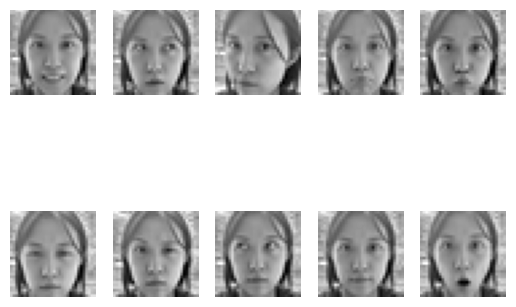

In [3]:
source_dir = os.path.join('PIE', 'my_orgimage')
target_dir = os.path.join('PIE', '69')
if not os.path.exists(target_dir):
    os.mkdir(target_dir)

image_paths = sorted([f for f in os.listdir(source_dir) if f.endswith('.jpg')])
num_rows = 2
num_columns = 5

def process_image(img_path, source_dir, target_dir):
    img = Image.open(os.path.join(source_dir, img_path)).convert('L')
    width, height = img.size
    img = img.crop((width // 8, height // 8, 7 * width // 8, 7 * height // 8)).resize((32, 32), Image.LANCZOS)
    return img

for i, img_path in enumerate(image_paths):
    img = process_image(img_path, source_dir, target_dir)
    plt.subplot(num_rows, num_columns, i % (num_rows * num_columns) + 1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    if not os.path.exists(os.path.join(target_dir, img_path)):
        img.save(os.path.join(target_dir, img_path))
plt.show()

### Whole Dataset

In [4]:
import random
import numpy as np
from sklearn.model_selection import train_test_split

In [5]:
random.seed(77)
subjects = [69] + random.sample(range(1, 69), 25)
print('26 subject numbers:', subjects)

n_imgs_subj = [len([f for f in os.listdir(os.path.join('PIE', str(s))) if f.endswith('.jpg')]) for s in subjects]
n_imgs = sum(n_imgs_subj) 
print('number of images per subject: {}'.format(n_imgs_subj))

X = np.empty((n_imgs, 32, 32))
y = np.empty((n_imgs, 1))

for si, s in enumerate(subjects):
    for i, img_path in enumerate([f for f in os.listdir(os.path.join('PIE', str(s))) if f.endswith('.jpg')]):
        img_path = os.path.join('PIE', str(s), str(i+1)+'.jpg')
        X[sum(n_imgs_subj[:si]) + i, :, :] = np.array(Image.open(img_path))
        y[sum(n_imgs_subj[:si]) + i] = s
print('X or dataset shape: {}\ny or label shape: {}'.format(X.shape, y.shape))

# Split the data into CMUPIE and selfie subsets
X_CMUPIE = X[y.flatten() != 69]
y_CMUPIE = y[y != 69]
X_selfies = X[y.flatten() == 69]
y_selfies = y[y == 69]
X_train_CMUPIE, X_test_CMUPIE, y_train_CMUPIE, y_test_CMUPIE = train_test_split(
    X_CMUPIE, y_CMUPIE, test_size=0.3, random_state=77)
X_train_selfies, X_test_selfies, y_train_selfies, y_test_selfies = train_test_split(
    X_selfies, y_selfies, test_size=0.3, random_state=77)
X_train = np.concatenate([X_train_CMUPIE, X_train_selfies], axis=0)
y_train = np.concatenate([y_train_CMUPIE, y_train_selfies], axis=0)
X_test = np.concatenate([X_test_CMUPIE, X_test_selfies], axis=0)
y_test = np.concatenate([y_test_CMUPIE, y_test_selfies], axis=0)
print('The number of images in train set: {}\nThe number of images in in test set: {}'.format(y_train.shape[0], y_test.shape[0]))

26 subject numbers: [69, 33, 42, 26, 31, 25, 53, 61, 8, 19, 65, 36, 40, 16, 10, 58, 41, 43, 68, 1, 18, 2, 32, 12, 13, 51]
number of images per subject: [10, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170]
X or dataset shape: (4260, 32, 32)
y or label shape: (4260, 1)
The number of images in train set: 2982
The number of images in in test set: 1278


In [13]:
import numpy as np
from libsvm.svmutil import svm_train, svm_predict, svm_problem,svm_parameter
from sklearn.preprocessing import StandardScaler

class PCA:
    def __init__(self, n_components=2):
        self.n_components = n_components
        self.components_ = None
        self.explained_variance_ratio_ = None
        self.scaler = StandardScaler()

    def fit(self, X):
        X_normalized = self.scaler.fit_transform(X.reshape(X.shape[0], -1))
        X_corr = np.cov(X_normalized, rowvar=False)
        u, s, v = np.linalg.svd(X_corr)
        for i in range(u.shape[1]):
            if u[0, i] < 0:
                u[:, i] = -u[:, i]

        self.components_ = u[:, :self.n_components]
        self.explained_variance_ratio_ = s / np.sum(s)

    def transform(self, X):
        X_normalized = self.scaler.transform(X.reshape(X.shape[0], -1))
        return X_normalized.dot(self.components_)

    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)

def convert_to_libsvm_format(labels, features):
    data = []
    for i in range(len(labels)):
        feature_dict = {j+1: features[i][j] for j in range(len(features[i]))}
        data.append((labels[i], feature_dict))
    return data

X_train_vectorized = X_train.reshape(X_train.shape[0], -1)
X_test_vectorized = X_test.reshape(X_test.shape[0], -1)

pca_80 = PCA(n_components=80)
X_train_pca_80 = pca_80.fit_transform(X_train_vectorized)
X_test_pca_80 = pca_80.transform(X_test_vectorized)

pca_200 = PCA(n_components=200)
X_train_pca_200 = pca_200.fit_transform(X_train_vectorized)
X_test_pca_200 = pca_200.transform(X_test_vectorized)

for C in [1e-2, 1e-1, 1]:
    for X_train, X_test, data_description in [(X_train_vectorized, X_test_vectorized, 'Raw'), 
                                              (X_train_pca_80, X_test_pca_80, '80'), 
                                              (X_train_pca_200, X_test_pca_200, '200')]:
        
        train_data = convert_to_libsvm_format(y_train.ravel(), X_train)
        test_data = convert_to_libsvm_format(y_test.ravel(), X_test)
        prob = svm_problem([label for label, _ in train_data], [features for _, features in train_data])
        param = svm_parameter(f'-t 0 -c {C}') 
        model = svm_train(prob, param)
        
        p_label, p_acc, p_val = svm_predict([label for label, _ in test_data], [features for _, features in test_data], model)
        accuracy = p_acc[0]
        print(f"C={C}, Data dimension={data_description}, Accuracy={accuracy}")


Accuracy = 98.8263% (1263/1278) (classification)
C=0.01, Data dimension=Raw, Accuracy=98.82629107981221
Accuracy = 90.7668% (1160/1278) (classification)
C=0.01, Data dimension=80, Accuracy=90.76682316118936
Accuracy = 97.7308% (1249/1278) (classification)
C=0.01, Data dimension=200, Accuracy=97.73082942097027
Accuracy = 98.8263% (1263/1278) (classification)
C=0.1, Data dimension=Raw, Accuracy=98.82629107981221
Accuracy = 91.3146% (1167/1278) (classification)
C=0.1, Data dimension=80, Accuracy=91.31455399061032
Accuracy = 97.8873% (1251/1278) (classification)
C=0.1, Data dimension=200, Accuracy=97.88732394366197
Accuracy = 98.8263% (1263/1278) (classification)
C=1, Data dimension=Raw, Accuracy=98.82629107981221
Accuracy = 90.9233% (1162/1278) (classification)
C=1, Data dimension=80, Accuracy=90.92331768388107
Accuracy = 97.8873% (1251/1278) (classification)
C=1, Data dimension=200, Accuracy=97.88732394366197


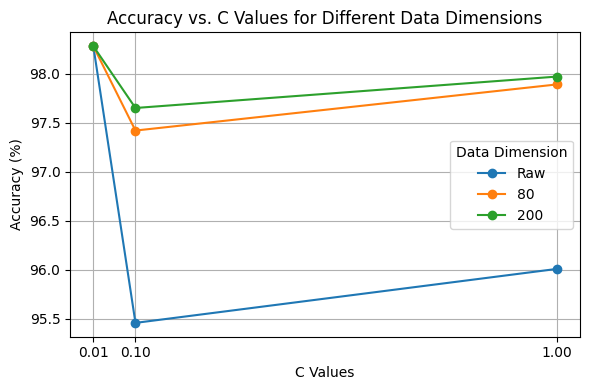

In [14]:
import matplotlib.pyplot as plt
C_values = [0.01, 0.1, 1]
data_dimensions = ['Raw', '80', '200']
accuracies = [
    [98.28, 95.46, 96.01],
    [98.28, 97.42, 97.89],
    [98.28, 97.65, 97.97]
]
plt.figure(figsize=(6, 4))

for i, dim in enumerate(data_dimensions):
    plt.plot(
        C_values,
        accuracies[i],
        marker='o',
        label=f'Data dimension={dim}')
plt.xlabel('C Values')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy vs. C Values for Different Data Dimensions')
plt.xticks(C_values)
plt.legend(data_dimensions, title='Data Dimension')

plt.grid()
plt.tight_layout()
plt.show()